In [0]:
#import all necessary packages
import torch

In [0]:
import torchvision
import numpy as np
import torchvision.transforms as tvt
import matplotlib.pyplot as plt


In [0]:
transform=tvt.Compose([tvt.ToTensor(),tvt.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])   #normalise all images with mean and variance=0.5

In [4]:
#download the CiFAR10 dataset
train_data_loc=torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
test_data_loc = torchvision.datasets.CIFAR10(root='./data', train=False,download=True,transform=transform)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
## from the given dataset separate out cats and dogs images.

#find the images with labels 3=cats and 5=dogs
lst=[]
for i in range(len(train_data_loc.targets)):
  if train_data_loc.targets[i]==3 or train_data_loc.targets[i]==5:
    lst.append(i)

In [0]:
#create a subset of the CiFAR10 dataset
cats_dogs=torch.utils.data.Subset(train_data_loc,lst)

In [0]:
#create the dataloader
trainloader=torch.utils.data.DataLoader(cats_dogs, batch_size=5,shuffle=True,worker_init_fn=2)

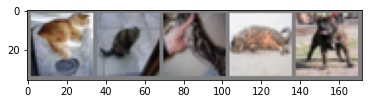

tensor(3) tensor(3) tensor(3) tensor(3) tensor(5)


In [21]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j] for j in range(5)))

In [0]:
dtype = torch.float

In [0]:
#The network consists of 2 hidden layers with 1000 and 256 neurons
N, D_in, H1, H2, D_out = 8, 3*32*32, 1000, 256, 2
# Randomly initialize weights
w1 = torch.randn(D_in, H1, dtype=dtype)
w2 = torch.randn(H1, H2, dtype=dtype)
w3 = torch.randn(H2, D_out, dtype=dtype)
learning_rate = 1e-8


138238.01223242196
79824.50870957036
51917.18528476557
36820.72265166015
27654.157197851586
21708.64196418459
17566.40522470706
14548.827631713872
12380.247983703603
10666.07585622559
9259.589579138192
8121.278355969234
7219.238230889888
6459.815556127925
5840.330846813963
5307.122729641721
4843.5438892700195
4450.783053593446
4093.2664968261683
3790.3003427185067
3520.125917738344
3278.9082156814516
3046.7411152084405
2864.0591418243403
2693.8204948089615
2541.3155092865045
2402.866537853996
2267.283723156739
2155.7145505218477
2045.512149747465
1945.3530616699204
1848.5324559524524
1777.3064413948064
1695.7112546676626
1620.1165748847943
1551.0791191650378
1488.1021800971982
1423.0005251022337
1376.6343185928379
1317.0694941520685
1272.3375582229573
1227.4963665237403
1183.720176828005
1143.8563141696916
1104.7911038909901
1061.3249482902522
1028.466192876434
1001.1438100219734
967.039320084761
934.8876352455123


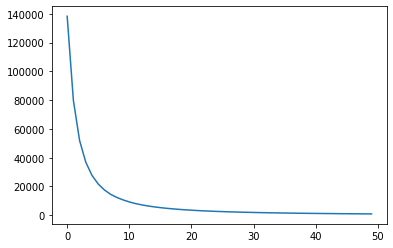

In [11]:
#create a Fully Connected Network from scratch
loss_data=[]
for t in range(50):
  loss=0
  loss1=0
  for i, data in enumerate(trainloader):
    inputs, labels = data
    x = inputs.view(inputs.size(0), -1)               #flatten the image from a matrix to a vector
    y=labels.clone()

    #change labels to 0,1
    for i in range(len(y)):
      if y[i]==3:
        y[i]=0
      elif y[i]==5:
        y[i]=1
    
    #one hot encode the labels
    y=torch.nn.functional.one_hot(y,2)

    #build the network
    h1 = x.mm(w1) ## In numpy, you would say h1 = x.dot(w1)
    h1_relu = h1.clamp(min=0)
    h2 = h1_relu.mm(w2)
    h2_relu = h2.clamp(min=0)
    y_pred = h2_relu.mm(w3)
    loss = ((y_pred - y).pow(2).sum().item())/5               #define the MSE loss
    #if t%10==1:
      #print(loss)
    y_error = (y_pred - y)/5

#find the gradients and update the weights
    grad_w3 = h2_relu.t().mm(2 * y_error)
    h2_error = 2.0 * y_error.mm(w3.t())
    h2_error[h2 < 0] = 0
  

    grad_w2 = h1_relu.t().mm(h2_error)
    h1_error = h2_error.mm(w2.t())
    h1_error[h1 < 0] = 0

    grad_w1 = x.t().mm(h1_error)

    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2
    w3 -= learning_rate * grad_w3
    loss1=loss1+(loss/2000)  
  print(loss1)
  loss_data.append(loss1)
  
plt.plot(loss_data)
  


In [0]:
#Testing the model
lst1=[]
for i in range(len(test_data_loc.targets)):
  if test_data_loc.targets[i]==3 or test_data_loc.targets[i]==5:
    lst1.append(i)


In [0]:
cats_dogs_test=torch.utils.data.Subset(test_data_loc,lst1)
testloader=torch.utils.data.DataLoader(cats_dogs_test, batch_size=5,shuffle=False,worker_init_fn=2)

In [25]:
right=0
conf_mat=np.zeros([2,2])
for i, data in enumerate(testloader):
    ynew=[]
    inputs, labels = data
    x = inputs.view(inputs.size(0), -1)
    y=labels.clone()
    for i in range(len(y)):
      if y[i]==3:
        y[i]=0
      elif y[i]==5:
        y[i]=1
    yline=y.clone()
    y=torch.nn.functional.one_hot(y,2)
    h1 = x.mm(w1) ## In numpy, you would say h1 = x.dot(w1)
    h1_relu = h1.clamp(min=0)
    h2 = h1_relu.mm(w2)
    h2_relu = h2.clamp(min=0)
    y_pred = h2_relu.mm(w3)
    y_sm=torch.nn.functional.softmax(y_pred)
    #decide which class the output belongs to
    for cr,dr in y_sm:
      if cr>dr:
        ynew.append(0)
      else:
        ynew.append(1)
    
    #accuracy
    for k in range(len(ynew)):
      if yline[k]==ynew[k]:
        right+=1
    
    #confusion matrix
    for k in range(len(ynew)):
      conf_mat[yline[k]][ynew[k]]+=1
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [26]:
accuracy=right/len(cats_dogs_test)
print(conf_mat)

[[ 97. 903.]
 [ 97. 903.]]


In [0]:
import sys

orig_stdout = sys.stdout
f = open('output.txt', 'w')
sys.stdout = f

for i in range(len(loss_data)):
  print('Epoch '+str(i)+': '+str(loss_data[i]))
print()
print('Test Accuracy :'+str(accuracy*100))

sys.stdout = orig_stdout
f.close()